In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib import rcParams
from matplotlib.cm import rainbow
import warnings
warnings.filterwarnings('ignore')
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.4
      /_/

Using Python version 3.7.4 (default, Aug 13 2019 15:17:50)
SparkSession available as 'spark'.


In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql import DataFrameReader
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import *

In [3]:
spark = SparkSession \
    .builder \
    .appName('pyspark_demo_app') \
    .config('spark.driver.extraClassPath',
            'postgresql-42.2.9') \
    .master("local[*]") \
    .getOrCreate()

In [4]:
# tips on jdbc ... https://sparkour.urizone.net/recipes/using-jdbc/#03
# Load properties from file
import json
with open("../data-load/Resources/db-properties.json") as propertyFile:
    properties = json.load(propertyFile)

dbMode = "overwrite"
jdbc_url= properties["jdbcUrl"]
dbConfig = {"user": properties["user"], 
          "password": properties["password"], 
          "driver": properties["driver"]
         }

In [5]:
entireDF = spark.read.jdbc(url=jdbc_url, table = 'heart_cardio_train', properties=dbConfig)
entireDF.printSchema()
entireDF.limit(5).show()

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)
 |-- age_yrs: integer (nullable = true)
 |-- weight_lbs: decimal(38,18) (nullable = true)
 |-- height_inches: decimal(38,18) (nullable = true)
 |-- bmi: decimal(38,18) (nullable = true)
 |-- bmi_category: string (nullable = true)

+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+-------+--------------------+--------------------+--------------------+------------+
|   id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|age_yr

In [6]:
#convert to pandas df
heart_cardio = entireDF.select("*").toPandas()
heart_cardio.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_yrs,weight_lbs,height_inches,bmi,bmi_category
0,54329,14395,1,158,46.0,110,70,1,1,0,0,1,0,39,101.410000000000000000,62.000000000000000000,18.430000000000000000,Underweight
1,54400,20571,2,166,48.0,120,90,2,1,0,0,1,0,56,105.820000000000000000,65.000000000000000000,17.420000000000000000,Underweight
2,14908,22007,1,162,38.0,100,70,1,1,0,0,1,0,60,83.780000000000000000,64.000000000000000000,14.480000000000000000,Underweight
3,54860,18290,2,171,51.0,140,80,3,1,1,1,1,1,50,112.440000000000000000,67.000000000000000000,17.440000000000000000,Underweight
4,54895,23113,2,167,48.0,140,80,1,1,0,0,1,1,63,105.820000000000000000,66.000000000000000000,17.210000000000000000,Underweight


In [7]:
#Check duplicate values
print("There is {} duplicated values in data frame".format(heart_cardio.duplicated().sum()))


There is 0 duplicated values in data frame


In [8]:
#Drop duplicate values
heart_cardio.drop_duplicates(inplace=True)
print("There is {} duplicated values in data frame".format(heart_cardio.duplicated().sum()))

There is 0 duplicated values in data frame


## Drop duplicate columns that are in different units

In [9]:
heart_cardio=heart_cardio.drop(columns=['id','age', 'height','weight', 'bmi_category'], axis=1)
heart_cardio.head()

,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_yrs,weight_lbs,height_inches,bmi
0,1,110,70,1,1,0,0,1,0,39,101.410000000000000000,62.000000000000000000,18.430000000000000000
1,2,120,90,2,1,0,0,1,0,56,105.820000000000000000,65.000000000000000000,17.420000000000000000
2,1,100,70,1,1,0,0,1,0,60,83.780000000000000000,64.000000000000000000,14.480000000000000000
3,2,140,80,3,1,1,1,1,1,50,112.440000000000000000,67.000000000000000000,17.440000000000000000
4,2,140,80,1,1,0,0,1,1,63,105.820000000000000000,66.000000000000000000,17.210000000000000000


In [10]:
#Rename columns
heart_cardio=heart_cardio.rename(columns={"ap_hi": "systolic pressure", "ap_lo": "diastolic pressure", "alco": "alcohol"})
heart_cardio.head()

,gender,systolic pressure,diastolic pressure,cholesterol,gluc,smoke,alcohol,active,cardio,age_yrs,weight_lbs,height_inches,bmi
0,1,110,70,1,1,0,0,1,0,39,101.410000000000000000,62.000000000000000000,18.430000000000000000
1,2,120,90,2,1,0,0,1,0,56,105.820000000000000000,65.000000000000000000,17.420000000000000000
2,1,100,70,1,1,0,0,1,0,60,83.780000000000000000,64.000000000000000000,14.480000000000000000
3,2,140,80,3,1,1,1,1,1,50,112.440000000000000000,67.000000000000000000,17.440000000000000000
4,2,140,80,1,1,0,0,1,1,63,105.820000000000000000,66.000000000000000000,17.210000000000000000


# Data-preprocessing

In [11]:
heart_cardio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68638 entries, 0 to 68637
Data columns (total 13 columns):
gender                68638 non-null int32
systolic pressure     68638 non-null int32
diastolic pressure    68638 non-null int32
cholesterol           68638 non-null int32
gluc                  68638 non-null int32
smoke                 68638 non-null int32
alcohol               68638 non-null int32
active                68638 non-null int32
cardio                68638 non-null int32
age_yrs               68638 non-null int32
weight_lbs            68638 non-null object
height_inches         68638 non-null object
bmi                   68638 non-null object
dtypes: int32(10), object(3)
memory usage: 4.7+ MB


In [12]:
#Change object types to int types
heart_cardio['weight_lbs']=heart_cardio['weight_lbs'].astype(int)
heart_cardio['height_inches']=heart_cardio['height_inches'].astype(int)
heart_cardio['bmi']=heart_cardio['bmi'].astype(int)
heart_cardio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68638 entries, 0 to 68637
Data columns (total 13 columns):
gender                68638 non-null int32
systolic pressure     68638 non-null int32
diastolic pressure    68638 non-null int32
cholesterol           68638 non-null int32
gluc                  68638 non-null int32
smoke                 68638 non-null int32
alcohol               68638 non-null int32
active                68638 non-null int32
cardio                68638 non-null int32
age_yrs               68638 non-null int32
weight_lbs            68638 non-null int64
height_inches         68638 non-null int64
bmi                   68638 non-null int64
dtypes: int32(10), int64(3)
memory usage: 4.7 MB


## Exploratory Data Analysis

In [13]:
#Check min, max, mean and identify outliers
heart_cardio.describe()

,gender,systolic pressure,diastolic pressure,cholesterol,gluc,smoke,alcohol,active,cardio,age_yrs,weight_lbs,height_inches,bmi
count,68638.000000,68638.000000,68638.000000,68638.000000,68638.000000,68638.000000,68638.000000,68638.000000,68638.000000,68638.000000,68638.000000,68638.000000,68638.000000
mean,1.348845,126.621361,81.369358,1.365002,1.226085,0.088085,0.053644,0.803447,0.494974,52.829409,162.933783,64.773216,26.962237
std,0.476608,16.755176,9.592397,0.679173,0.572060,0.283421,0.225315,0.397394,0.499978,6.768847,31.500576,3.140108,5.235715
min,1.000000,70.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.000000,77.000000,48.000000,12.000000
25%,1.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000,143.000000,63.000000,23.000000
50%,1.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.000000,158.000000,65.000000,26.000000
75%,2.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000,180.000000,67.000000,30.000000
max,2.000000,240.000000,160.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.000000,440.000000,81.000000,108.000000


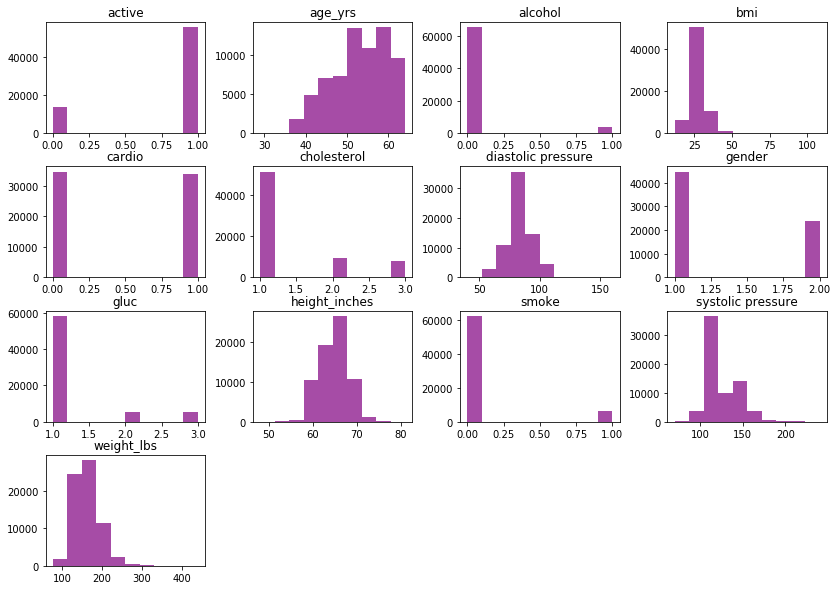

In [14]:
#Check data distribution
heart_cardio.hist(figsize=(14,10), color="purple",alpha=0.7, grid=False);

Percentage of data distribution in the two classes are:
50.5
49.5


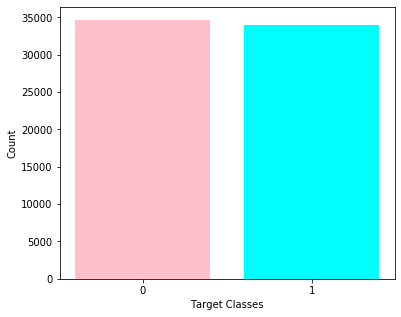

In [15]:
##Check count and Visualize data distribution in target
rcParams['figure.figsize'] = 6,5
plt.bar(heart_cardio['cardio'].unique(), heart_cardio['cardio'].value_counts(), color = ['pink','cyan'])
plt.xticks([0, 1])
plt.xlabel('Target Classes')
plt.ylabel('Count');

a,b=np.bincount(heart_cardio.cardio)
print(f"Percentage of data distribution in the two classes are:")
print(round(a/(a+b)*100,2))
print(round(b/(a+b)*100,2))

# Data Pre-Processing


### Feature Selection
#### 1.Univariate Selection:
The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features. The code below uses the chi-squared (chi²) statistical test to select 10 of the best features. 

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = heart_cardio.drop("cardio", axis=1) 
y = heart_cardio["cardio"]   
# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features
# X.head()
# y.head()

                 Specs         Score
1    systolic pressure  27531.126478
9           weight_lbs  13551.327729
2   diastolic pressure   8812.229274
8              age_yrs   3411.521806
11                 bmi   2532.921901
3          cholesterol   1137.484166
4                 gluc    148.083895
7               active     18.816883
5                smoke     16.645620
6              alcohol      4.379963


#### 2. Feature importance:
Feature importance is an inbuilt class that comes with Tree Based Classifiers. Extra Tree Classifier is used for extracting the top 10 features for the dataset.

[0.01152579 0.18969893 0.10317298 0.04578004 0.01523953 0.00730416
 0.00595112 0.00785398 0.17645152 0.18965729 0.1234414  0.12392326]


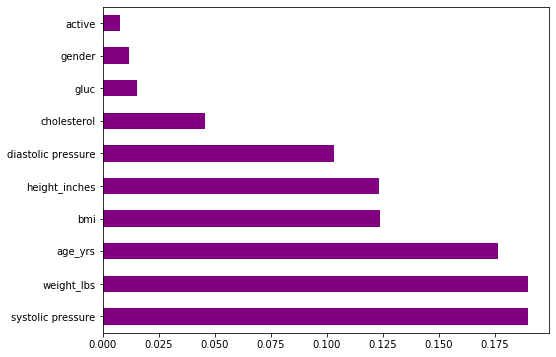

In [18]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 8,6
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', color='purple')
plt.show()

#### 3.Correlation Matrix with Heatmap
Correlation heatmap is built using the seaborn library to identify which features are most related to each other or the target variable. 

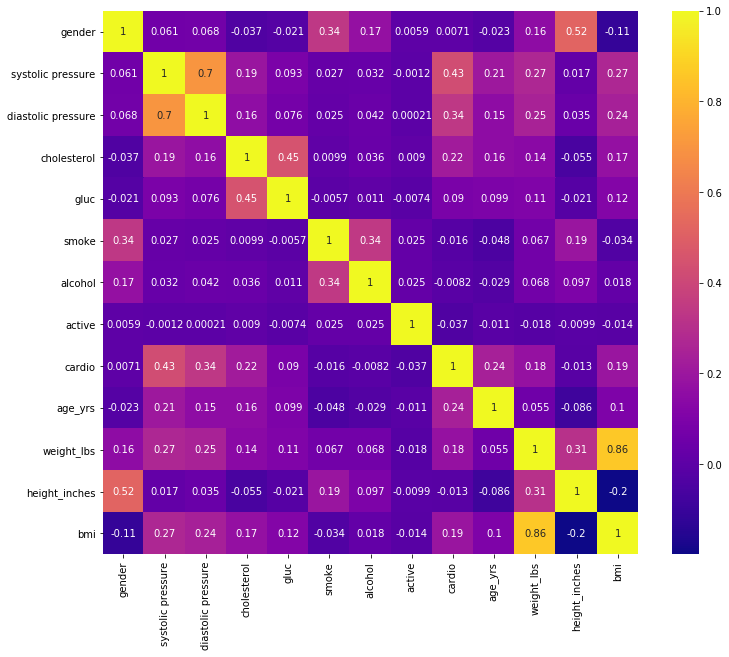

In [19]:
#get correlations of each features in dataset
import seaborn as sns
corrmat = heart_cardio.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(12,10))
#plot heat map
g=sns.heatmap(heart_cardio[top_corr_features].corr(),annot=True,cmap="plasma")

From analysis of the above three processes for feature selection, and distribution of data in categorical features as seen in the histograms above, the following features have been selected based on the feature name appearing in atleast two of the three selection tests above:
systolic pressure,diastolic pressure, bmi, age_yrs, weight_lbs, chol, gender, gluc. 
While smoke and alcohol are known to be great risk factors, but their distribution in the classes is highly imbalanced to train the model. Also, they show negative correlation with the target in the heatmap and don't appear in the feature importance plot.Active is selcted despite showing negative correlation as it appears in the other two selection processes.

In [20]:
#Drop rest of the features and create new df
feature_selected_df = heart_cardio.drop(['smoke', 'alcohol','height_inches', 'active'], axis=1)
feature_selected_df.head()

,gender,systolic pressure,diastolic pressure,cholesterol,gluc,cardio,age_yrs,weight_lbs,bmi
0,1,110,70,1,1,0,39,101,18
1,2,120,90,2,1,0,56,105,17
2,1,100,70,1,1,0,60,83,14
3,2,140,80,3,1,1,50,112,17
4,2,140,80,1,1,1,63,105,17


### Data Scaling

In [21]:
#Scaling continuous features using StandardScaler
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
columns_to_scale = ['age_yrs', 'bmi', 'weight_lbs', 'systolic pressure', 'diastolic pressure']
feature_selected_df[columns_to_scale] = standardScaler.fit_transform(feature_selected_df[columns_to_scale])
dataset=feature_selected_df
dataset.head()

,gender,systolic pressure,diastolic pressure,cholesterol,gluc,cardio,age_yrs,weight_lbs,bmi
0,1,-0.992021,-1.185255,1,1,0,-2.043112,-1.966130,-1.711763
1,2,-0.395186,0.899744,2,1,0,0.468413,-1.839147,-1.902760
2,1,-1.588856,-1.185255,1,1,0,1.059360,-2.537552,-2.475752
3,2,0.798484,-0.142756,3,1,1,-0.418008,-1.616928,-1.902760
4,2,0.798484,-0.142756,1,1,1,1.502570,-1.839147,-1.902760


In [22]:
target = dataset["cardio"]
data = dataset.drop("cardio", axis=1)
feature_names = data.columns
# target = feature_selected_df["cardio"]
# data = feature_selected_df.drop("cardio", axis=1)
# data.head()

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)
X_train.info()
X_test.count()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51478 entries, 58732 to 15795
Data columns (total 8 columns):
gender                51478 non-null int32
systolic pressure     51478 non-null float64
diastolic pressure    51478 non-null float64
cholesterol           51478 non-null int32
gluc                  51478 non-null int32
age_yrs               51478 non-null float64
weight_lbs            51478 non-null float64
bmi                   51478 non-null float64
dtypes: float64(5), int32(3)
memory usage: 2.9 MB


gender                17160
systolic pressure     17160
diastolic pressure    17160
cholesterol           17160
gluc                  17160
age_yrs               17160
weight_lbs            17160
bmi                   17160
dtype: int64

In [24]:
X_test.shape

(17160, 8)

In [25]:
# Check if the labels are well shuffled in train and test set, to avoid imbalanced data
a,b=np.bincount(y_train)
print(f"Percentage of data distribution in the train set:")
print(round(a/(a+b)*100,2))
print(round(b/(a+b)*100,2))
print("-------------------")
x,y=np.bincount(y_test)
print(f"Percentage of data distribution in the test set:")
print(round(x/(x+y)*100,2))
print(round(y/(x+y)*100,2))
# np.bincount(y_test)

Percentage of data distribution in the train set:
50.56
49.44
-------------------
Percentage of data distribution in the test set:
50.34
49.66


## Applying Machine Learning Algorithms



In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


#### Logistic Regression

In [27]:
lg = LogisticRegression()
# Create an instance of Logistic Regression Classifier and fit the data.
lg.fit(X_train,y_train)
lg_score=round(lg.score(X_train,y_train)*100,2)
lg_score

72.68

### K Neighbors Classifier
The classification parameters are values of neighbors (k) and distance. Different values of neighbours will be used to check the best output score.

In [28]:
#Hold the scores for various neighbors i.e. k in a list
knn_scores = []
for i in range(1,20):
    knn_classifier = KNeighborsClassifier(n_neighbors = i)
    knn_classifier.fit(X_train, y_train)
    knn_scores.append(round(knn_classifier.score(X_test, y_test)*100,2))
        
knn_scores

[64.42,
 64.39,
 68.06,
 67.91,
 69.34,
 69.69,
 70.45,
 70.64,
 70.83,
 71.29,
 71.55,
 71.55,
 71.92,
 71.89,
 72.01,
 72.3,
 72.3,
 72.35,
 72.4]

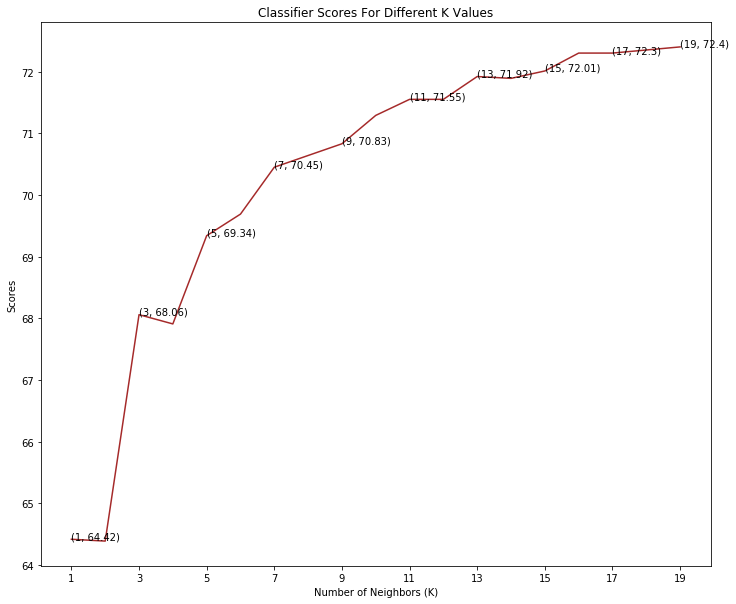

In [29]:
rcParams['figure.figsize'] = 12,10
plt.plot([i for i in range(1, 20)], knn_scores, color = 'brown' )
for i in range(1,20,2):
    plt.text(i, knn_scores[i-1], (i, knn_scores[i-1]))
#     plt.text(i, knn_scores[i-1])

plt.xticks([i for i in range(1, 20, 2)])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('Classifier Scores For Different K Values');

### Support Vector Classifier
First testing all kernels. Second, select the best kernel and perform Hyperparameter Tuning 

In [30]:
svc_scores = []
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for i in range(len(kernels)):
    svc_classifier = SVC(kernel = kernels[i])
    svc_classifier.fit(X_train, y_train)
    svc_scores.append(round(svc_classifier.score(X_test, y_test)*100,2))
svc_scores

[72.2, 72.57, 73.15, 61.44]

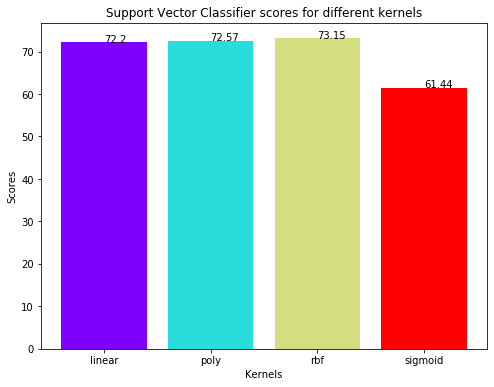

In [31]:
rcParams['figure.figsize'] = 8,6
colors = rainbow(np.linspace(0, 1, len(kernels)))
plt.bar(kernels, svc_scores, color = colors)
for i in range(len(kernels)):
    plt.text(i, svc_scores[i], svc_scores[i])
plt.xlabel('Kernels')
plt.ylabel('Scores')
plt.title('Support Vector Classifier scores for different kernels');

In [68]:
from sklearn.model_selection import GridSearchCV
from time import time
start=time()
model = SVC(kernel='rbf')
param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, verbose=3)
# Train the model with GridSearch
grid.fit(X_train, y_train)
print(f"time: {start}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... C=1, gamma=0.0001, score=0.717, total=  48.7s
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.7s remaining:    0.0s


[CV] ................... C=1, gamma=0.0001, score=0.728, total=  50.0s
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] ................... C=1, gamma=0.0001, score=0.718, total=  49.4s
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.723, total=  51.6s
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.727, total=  51.0s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.719, total=  46.6s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.729, total=  47.2s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.721, total=  47.8s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.727, total=  46.6s
[CV] C=1, gamma=0.0005 ...............................................
[CV] .

[CV] .................. C=50, gamma=0.0001, score=0.719, total=  46.4s
[CV] C=50, gamma=0.0001 ..............................................
[CV] .................. C=50, gamma=0.0001, score=0.730, total=  46.8s
[CV] C=50, gamma=0.0001 ..............................................
[CV] .................. C=50, gamma=0.0001, score=0.722, total=  46.3s
[CV] C=50, gamma=0.0001 ..............................................
[CV] .................. C=50, gamma=0.0001, score=0.727, total=  47.0s
[CV] C=50, gamma=0.0001 ..............................................
[CV] .................. C=50, gamma=0.0001, score=0.730, total=  46.9s
[CV] C=50, gamma=0.0005 ..............................................
[CV] .................. C=50, gamma=0.0005, score=0.723, total=  46.8s
[CV] C=50, gamma=0.0005 ..............................................
[CV] .................. C=50, gamma=0.0005, score=0.733, total=  46.4s
[CV] C=50, gamma=0.0005 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 63.5min finished


time: 1581293740.74982


In [69]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 5, 'gamma': 0.005}
0.730778293262509


In [29]:
svc_classifier = SVC(kernel = "rbf",C= 5, gamma = 0.005 )
svc_best_model_cardio=svc_classifier.fit(X_train, y_train)
svc_classifier.score(X_train, y_train)

0.7304479583511403

In [70]:
# Training score:
grid.score(X_train, y_train)

0.7304479583511403

In [71]:
# Testing score:
grid.score(X_test, y_test)

0.7280885780885781

In [72]:
# Print Classification Report.
# Make prediction and save to variable for report.
svc_predictions = grid.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, svc_predictions))

              precision    recall  f1-score   support

           0       0.70      0.79      0.75      8638
           1       0.76      0.66      0.71      8522

    accuracy                           0.73     17160
   macro avg       0.73      0.73      0.73     17160
weighted avg       0.73      0.73      0.73     17160



### Hyperparameter tuning: 
2nd approach was tested but the run continued for more than 24 hrs without giving any result. Had to cancel the run.

In [ ]:
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(kernel= 'rbf'), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

#### Decision Tree Classifier

Play around with `max_features` to see for best score. It determines how random each tree would be. Rule of thumb, for classification max_features=sqrt(n_features).

In [32]:
DT_scores = []
# since max_features is len(X.columns its sqrt will return floatingpoint which has to be typcast to int using the code below
# int(np.ceil(np.sqrt(len(X.columns) + 1)))
for i in range(1, int(np.ceil(np.sqrt(len(X.columns))))+1):
    DT_classifier = DecisionTreeClassifier(max_features = i, random_state = 0)
    DT_classifier.fit(X_train, y_train)
    DT_scores.append(round(DT_classifier.score(X_test, y_test)*100,2))
DT_scores

[65.06, 64.38, 64.99, 64.17]

#### Random Forest Classifier (Ensemble of Decision Tree)

Creating models with varying number of estimators i.e. number of trees to be built.

In [33]:
rf_scores = []
estimators = [10, 100, 200, 500, 700, 1000]
for i in estimators:
    rf_classifier = RandomForestClassifier(n_estimators = i, random_state = 0)
    rf_classifier.fit(X_train, y_train)
    rf_scores.append(round(rf_classifier.score(X_test, y_test)*100,2))
rf_scores

[68.47, 69.89, 70.05, 70.14, 70.06, 70.07]

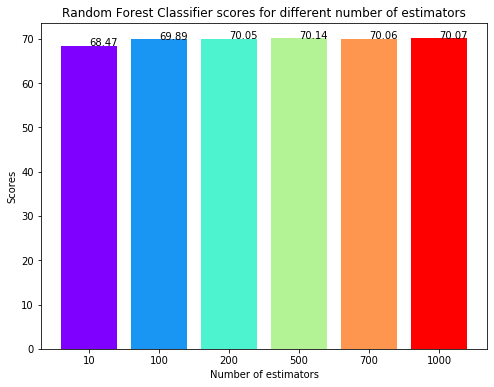

In [34]:
colors = rainbow(np.linspace(0, 1, len(estimators)))
plt.bar([i for i in range(len(estimators))], rf_scores, color = colors, width = 0.8)
for i in range(len(estimators)):
    plt.text(i, rf_scores[i], rf_scores[i])
plt.xticks(ticks = [i for i in range(len(estimators))], labels = [str(estimator) for estimator in estimators])
plt.xlabel('Number of estimators')
plt.ylabel('Scores')
plt.title('Random Forest Classifier scores for different number of estimators');

### Naive Bayes
Based on Bayes’ Theorem with an assumption of independence among predictors. Fast and relatively simple.It perform well in case of categorical input variables compared to numerical variable(s).Since our dataset has a higher number of categorical features, lets test the algorithm.

In [35]:
from sklearn.naive_bayes import GaussianNB
NB_classifier = GaussianNB()
NB_classifier.fit(X_train, y_train)


# Predicting the Test set results
y_pred = NB_classifier.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_pred, y_test)

y_pred_train = NB_classifier.predict(X_train)
cm_train = confusion_matrix(y_pred_train, y_train)

print()
print('Accuracy for training set for Naive Bayes = {}'.format((cm_train[0][0] + cm_train[1][1])/len(y_train)))
print('Accuracy for test set for Naive Bayes = {}'.format((cm_test[0][0] + cm_test[1][1])/len(y_test)))


Accuracy for training set for Naive Bayes = 0.7052138777730292
Accuracy for test set for Naive Bayes = 0.703962703962704


### Deep Learning
The perceptron model is used with the following parameters:
Sequential is a good model to begin with, The Relu and Softmax activation options are non-linear. Being able to use non-linear data makes Neural Network particularly useful.Using Sigmoid on an output layer with two categories (softmax for multiple categories).Using adam or rmsprop as the optimizer since both of them are pretty good.100 epoch will expose all of our training data in 100 loops to the network. More epochs means the network will know better about our data.

In [84]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop,Nadam,Adadelta,Adam
from tensorflow.keras.layers import BatchNormalization,LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
import scipy.stats as stats
import sklearn
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import warnings
from tensorflow.keras.utils import to_categorical

In [ ]:
X_train.shape[1]

In [86]:
# Model saved and tested used this criteria
NN_model = Sequential()
#add hidden layer
NN_model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
#add output layer, since it has 2 categories
NN_model.add(Dense(8, activation='relu'))
NN_model.add(Dense(1, activation='sigmoid'))
NN_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

#Adding validation_split=0.1 for creating a validation set with 10% data
NN_model.fit(X_train,y_train, epochs=100, verbose=2)


Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# #For one hot encoding
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

In [87]:
#Adding validation_split=0.1 for creating a validation set with 10% data
NN_model.fit(X_train,y_train, epochs=100, validation_split=0.1, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 2s - loss: 0.7818 - acc: 0.5586
Epoch 2/100
 - 2s - loss: 0.6716 - acc: 0.6030
Epoch 3/100
 - 2s - loss: 0.6486 - acc: 0.6259
Epoch 4/100
 - 2s - loss: 0.6380 - acc: 0.6408
Epoch 5/100
 - 2s - loss: 0.6276 - acc: 0.6538
Epoch 6/100
 - 2s - loss: 0.6237 - acc: 0.6587
Epoch 7/100
 - 2s - loss: 0.6207 - acc: 0.6641
Epoch 8/100
 - 2s - loss: 0.6157 - acc: 0.6717
Epoch 9/100
 - 2s - loss: 0.6099 - acc: 0.6746
Epoch 10/100
 - 2s - loss: 0.6065 - acc: 0.6799
Epoch 11/100
 - 2s - loss: 0.6023 - acc: 0.6848
Epoch 12/100
 - 2s - loss: 0.5977 - acc: 0.6905
Epoch 13/100
 - 2s - loss: 0.5990 - acc: 0.6891
Epoch 14/100
 - 2s - loss: 0.5948 - acc: 0.6940
Epoch 15/100
 - 2s - loss: 0.5941 - acc: 0.6953
Epoch 16/100
 - 2s - loss: 0.5921 - acc: 0.6968
Epoch 17/100
 - 2s - loss: 0.5889 - acc: 0.7005
Epoch 18/100
 - 2s - loss: 0.5885 - acc: 0.7023
Epoch 19/100
 - 2s - loss: 0.5864 - acc: 0.7037
Epoch 20/100
 - 2s - loss: 0.5880 - acc: 0.7017
E

In [88]:
NN_model_loss, NN_model_accuracy = NN_model.evaluate(
    X_test, y_test, verbose=2)
print(
    f"Normal Neural Network - Loss: {NN_model_loss}, Accuracy: {round(NN_model_accuracy*100,2)}")

Normal Neural Network - Loss: 0.5569088602955247, Accuracy: 72.33


In [89]:
test_score = NN_model.evaluate(X_test, y_test)
print("Testing Acc:", test_score)

17160/17160 [==============================] - 0s 17us/step
Testing Acc: [0.5569088602955247, 0.7232517482517482]


In [93]:
X_test.shape

(17160, 7)

In [97]:
# {‘age’: ‘25’, ‘gender’: ‘2’, ‘height’: ‘65’, ‘weight’: ‘130’, ‘ap_hi’: ‘120’, ‘ap_lo’: ‘78’, ‘cholesterol’: ‘1’}
A=[2, 120, 78, 1, 25, 130, 21.6]
Z=[2, 200, 120,3, 55,210,31]
B=np.array(Z)
# B
C=B.reshape(1, -1)
# C
NN_model.predict(C)
# C.shape

array([[0.97558844]], dtype=float32)

In [98]:
NN_model.save("NN_model.h5")
print("Saved model to disk")


Saved model to disk


In [102]:
from numpy import loadtxt
from keras.models import load_model
# load model
Best_model = load_model('NN_model.h5')
# summarize model.
Best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________


In [101]:
Best_model.predict_proba(C)

array([[0.97558844]], dtype=float32)

In [107]:
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV
# # def create_model(optimizer='adam'):
# # 	# create model
# # 	model = Sequential()
# # 	model.add(Dense(12, input_dim=8, activation='relu'))
# # 	model.add(Dense(1, activation='sigmoid'))
# # 	# Compile model
# # 	model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# # 	return model
# # fix random seed for reproducibility
# seed = 7
# np.random.seed(seed)
# # load dataset
# # dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# # # split into input (X) and output (Y) variables
# # X = dataset[:,0:8]
# # Y = dataset[:,8]
# # create model
# model = KerasClassifier(build_fn=NN_model, epochs=100, batch_size=10, verbose=0)
# # define the grid search parameters
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# param_grid = dict(optimizer=optimizer)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# Model Evaluation

Confusion Matrix, Precision, Recall, F1-score

### SVC best model evaluation

In [101]:
y_true = y_test
y_pred = svc_best_model_cardio.predict(X_test)

In [102]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

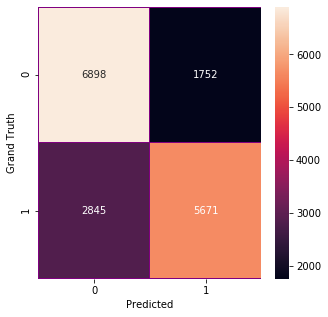

In [103]:
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm,fmt=".0f", annot=True,linewidths=0.2, linecolor="purple", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Grand Truth")
plt.show()

High precision relates to the low false positive rate.
High recall relates to the low false negative rate

In [104]:
TN = cm[0,0]
TP = cm[1,1]
FN = cm[1,0]
FP = cm[0,1]
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
F1_Score = 2*(Recall * Precision) / (Recall + Precision)
pd.DataFrame([[Precision, Recall, F1_Score]],columns=["Precision", "Recall", "F1 Score"], index=["Results"])

,Precision,Recall,F1 Score
Results,0.763977,0.665923,0.711588


### Neural Network best model evaluation

Confusion Matrix: 
 [[7201 1437]
 [3312 5210]]


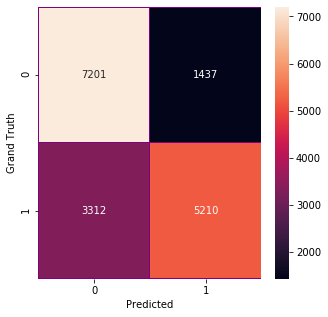

In [108]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

y_pred = NN_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred.round())
print("Confusion Matrix:", "\n", cm)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm,fmt=".0f", annot=True,linewidths=0.2, linecolor="purple", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Grand Truth")
plt.show()

In [109]:
TN = cm[0,0]
TP = cm[1,1]
FN = cm[1,0]
FP = cm[0,1]
Precision_NN = TP/(TP+FP)
Recall_NN = TP/(TP+FN)
F1_Score_NN = 2*(Recall_NN * Precision_NN) / (Recall_NN + Precision_NN)
pd.DataFrame([[Precision_NN, Recall_NN, F1_Score_NN]],columns=["Precision_NN", "Recall_NN", "F1 Score_NN"], index=["Results"])

,Precision_NN,Recall_NN,F1 Score_NN
Results,0.783812,0.611359,0.686927


# Saving the best model

In [ ]:
#save best model (so far it is svc wth 73% score)
# from sklearn.externals import joblib
# svc_classifier = SVC(kernel = "rbf",C= 5, gamma = 0.005 )
# svc_best_model_cardio=svc_classifier.fit(X_train, y_train)
# svc_classifier.score(X_train, y_train)


In [31]:
#load model and use
from sklearn.externals import joblib
joblib.dump(svc_best_model_cardio, 'model_svc.pkl')
loaded_model = joblib.load(open('model_svc.pkl', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.7280885780885781


In [ ]:
# {‘age’: ‘25’, ‘gender’: ‘2’, ‘height’: ‘65’, ‘weight’: ‘130’, ‘ap_hi’: ‘120’, ‘ap_lo’: ‘78’, ‘cholesterol’: ‘1’}
A=[2, 120, 78, 1, 25, 130, 21.6]
B=np.array(A)
# B
C=B.reshape(1, -1)
# C
svc_predictions = loaded_model.predict(A)
svc_predictions